In [1]:
from collections import defaultdict

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [2]:
data = anndata.read_h5ad('data/Group_6.h5ad')

In [3]:
# data.X.toarray()

Renaming "CD8+/CD45RA+ Naive Cytotoxic" to "CD8+/CD45RA+" so it is more inline with other names and doesn't cause issues on graphs

In [4]:
data.obs["cell-types"] = data.obs["cell-types"].replace("CD8+/CD45RA+ Naive Cytotoxic", "CD8+/CD45RA+")

/tmp/ipykernel_7169/999772727.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data.obs["cell-types"] = data.obs["cell-types"].replace("CD8+/CD45RA+ Naive Cytotoxic", "CD8+/CD45RA+")


In [5]:
# We will record the original cell type counts to make sure QC doesn't disproportionately remove any cell types
original_cell_type_counts = data.obs["cell-types"].value_counts()

We don't want to include genes that are expressed in very few cells, as they are unlikely to provide useful information for downstream analysis.
We can start with a general look at how many cells express each gene.

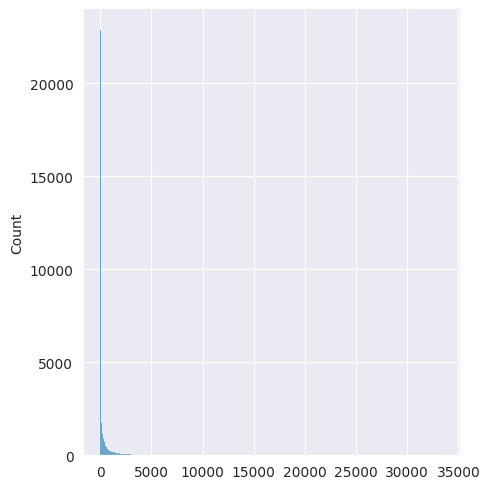

In [6]:
cells_per_gene = (data.X.toarray() > 0).sum(axis=0)
sns.displot(cells_per_gene)
plt.show()

To get a better idea of how many genes would be removed at different thresholds, we can plot the cumulative number of genes that would be removed as we increase the minimum cell threshold.

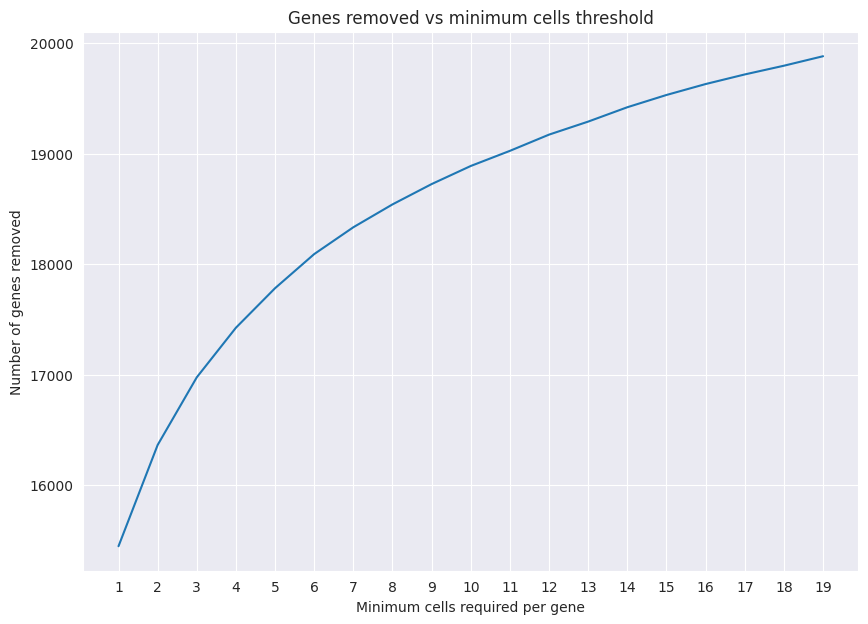

In [7]:
cumsum = np.cumsum(np.bincount(cells_per_gene))

removed = []
for m in range(1, 20):
    removed.append(int(cumsum[m]))

plt.figure(figsize=(10, 7))
plt.plot(range(1, 20), removed)
plt.xlabel("Minimum cells required per gene")
plt.ylabel("Number of genes removed")
plt.title("Genes removed vs minimum cells threshold")
plt.xticks(range(1, 20))
plt.grid(True)
plt.show()

The inflection point seems to be around 3-5 cells, so we will err on the side of caution and filter out genes that are expressed in fewer than 3 cells. Lets check how many genes that removes.

In [8]:
before = data.shape[1]
sc.pp.filter_genes(data, min_cells=3)
print("Genes removed:", before - data.shape[1])

Genes removed: 16362


Next we can look at the distribution of how many genes are detected per cell to identify potential outliers.

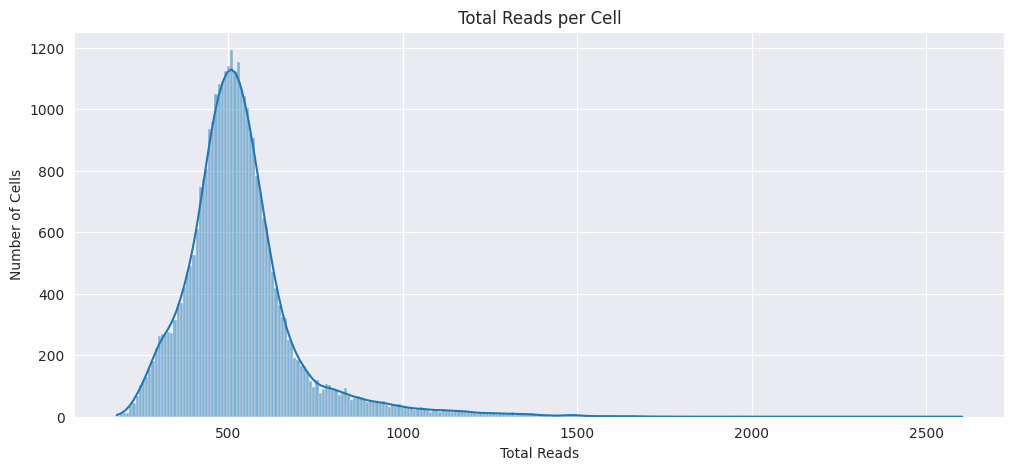

In [9]:
genes_per_cell = (data.X.toarray() > 0).sum(axis=1)

plt.figure(figsize=(12, 5))
sns.histplot(genes_per_cell, kde=True)
plt.title('Total Reads per Cell')
plt.xlabel('Total Reads')
plt.ylabel('Number of Cells')
plt.show()

Let's use the median absolute deviation (MAD) to identify outlier genes that are expressed in an unusually high or low number of cells.

Percent of cells removed by filtering: 11.457214464733257


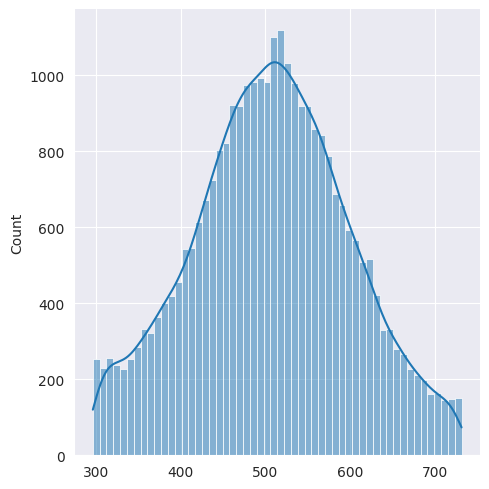

In [10]:
median = pd.Series(genes_per_cell).median()
mad = pd.Series((genes_per_cell - median)).abs().median()
upper_bound = median + 3 * mad
lower_bound = median - 3 * mad

data_filtered = data[genes_per_cell > lower_bound, :]
data_filtered = data_filtered[(data_filtered.X.toarray() > 0).sum(axis=1) < upper_bound, :]
print("Percent of cells removed by filtering:", 100 * (1 - data_filtered.shape[0] / data.shape[0]))
sns.displot((data_filtered.X.toarray() > 0).sum(axis=1), kde=True)
plt.show()

We are left with a cleaner dataset without the long tail of outlier cells which would likely skew downstream analyses, while only removing about 11% of the cells.

/tmp/ipykernel_7169/4100890292.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, after_qc_counts[i] + 0.5, f"{v:.1f}%", ha='right', fontsize=10)


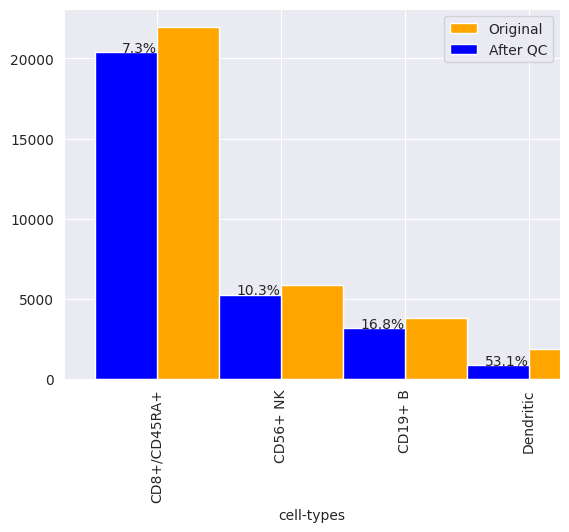

In [11]:
original_cell_type_counts.plot(kind='bar', color='orange', label='Original', position=0)
after_qc_counts = data_filtered.obs["cell-types"].value_counts()
after_qc_counts.plot(kind='bar', color='blue', label='After QC', position=1)

percent_drop = 100 * (original_cell_type_counts - after_qc_counts) / original_cell_type_counts
for i, v in enumerate(percent_drop):
    plt.text(i, after_qc_counts[i] + 0.5, f"{v:.1f}%", ha='right', fontsize=10)

plt.legend()
plt.show()

There is a clear bias against the Dendritic cells, which had a much higher percentage of cells removed compared to the other cell types. We can investigate this further by plotting the distribution of genes detected per cell for each cell type.

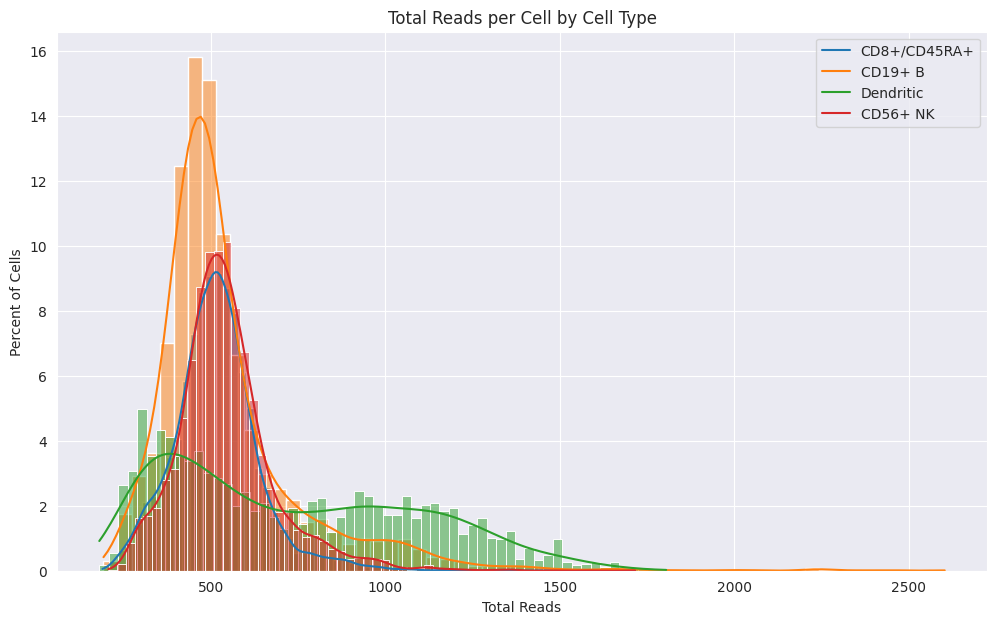

In [12]:
cell_types = data.obs["cell-types"].unique()

plt.figure(figsize=(12, 7))
plt.title('Total Reads per Cell by Cell Type')
plt.xlabel('Total Reads')
plt.ylabel('Percent of Cells')

for cell_type in cell_types:
    cell_type_indexes = data.obs[data.obs["cell-types"] == cell_type].index
    genes_per_cell = (data[cell_type_indexes].X.toarray() > 0).sum(axis=1)

    sns.histplot(genes_per_cell, kde=True, label=cell_type, stat="percent", bins=60)

plt.legend([ct for ct in cell_types])
plt.show()

There is a clear distrbution difference in the Dendritic cells compared to the other cell types. To account for this, we can apply cell type specific QC thresholds based on the MAD for each cell type individually.

CD8+/CD45RA+ lower bound: 311.0 upper bound: 713.0
CD19+ B lower bound: 263.0 upper bound: 719.0
Dendritic lower bound: -200.0 upper bound: 1516.0
CD56+ NK lower bound: 321.0 upper bound: 735.0
Percent of cells removed by filtering: 10.180212435851532


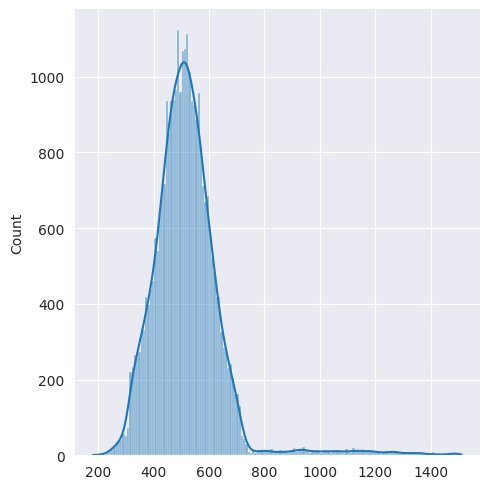

In [13]:
filtered_data = []
for ct in cell_types:
    genes_per_cell = (data[data.obs["cell-types"] == ct].X.toarray() > 0).sum(axis=1)
    median = pd.Series(genes_per_cell).median()
    mad = pd.Series((genes_per_cell - median)).abs().median()
    upper_bound = median + 3 * mad
    lower_bound = median - 3 * mad
    print(ct, "lower bound:", lower_bound, "upper bound:", upper_bound)

    ct_filtered = data[data.obs["cell-types"] == ct][(genes_per_cell > lower_bound) & (genes_per_cell < upper_bound), :]
    filtered_data.append(ct_filtered)

data_filtered_per_cell = anndata.concat(filtered_data)
print("Percent of cells removed by filtering:", 100 * (1 - data_filtered_per_cell.shape[0] / data.shape[0]))

sns.displot((data_filtered_per_cell.X.toarray() > 0).sum(axis=1), kde=True)
plt.show()

/tmp/ipykernel_7169/345978520.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[0].text(i, after_qc_counts[i] + 0.5, f"{v:.1f}%", ha='right', fontsize=10)
/tmp/ipykernel_7169/345978520.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[1].text(i, after_qc_counts[i] + 0.5, f"{v:.1f}%", ha='right', fontsize=10)


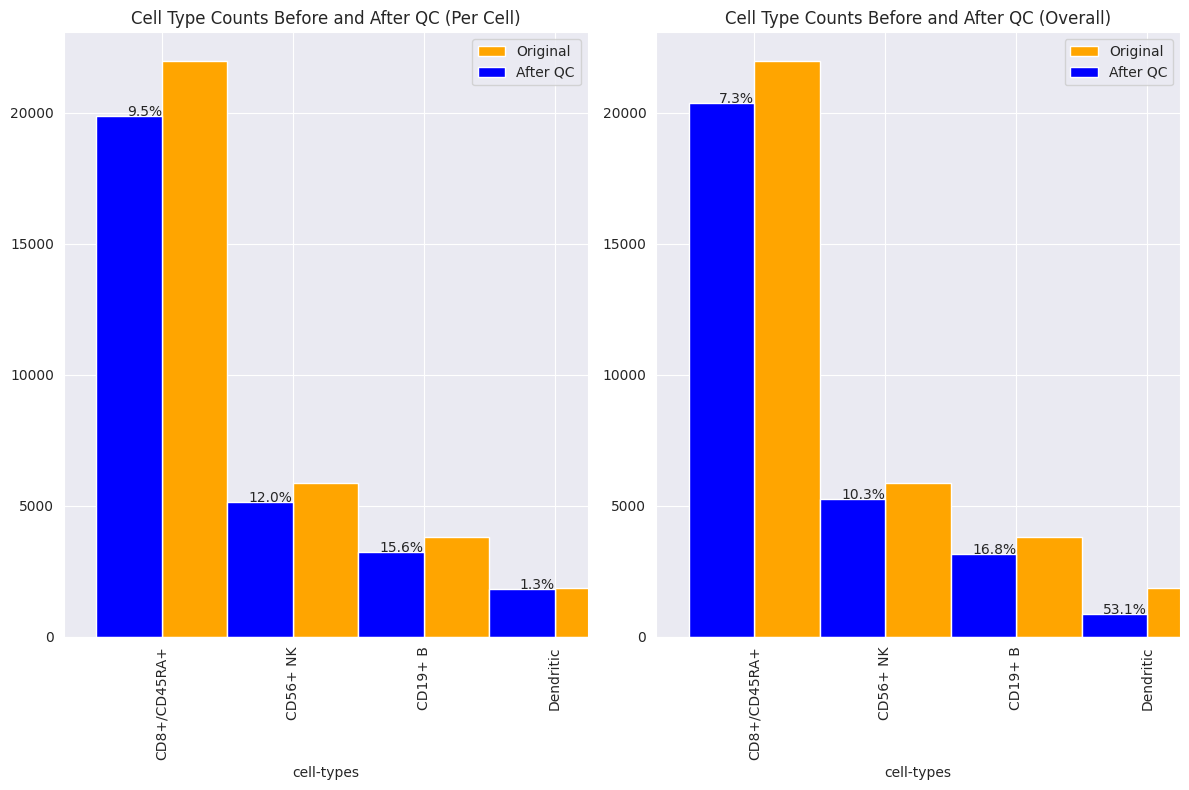

In [14]:

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# First subplot
original_cell_type_counts.plot(kind='bar', color='orange', label='Original', ax=axes[0], position=0)
after_qc_counts = data_filtered_per_cell.obs["cell-types"].value_counts()
after_qc_counts.plot(kind='bar', color='blue', label='After QC', ax=axes[0], position=1)

percent_drop = 100 * (original_cell_type_counts - after_qc_counts) / original_cell_type_counts
for i, v in enumerate(percent_drop):
    axes[0].text(i, after_qc_counts[i] + 0.5, f"{v:.1f}%", ha='right', fontsize=10)

axes[0].legend()
axes[0].set_title("Cell Type Counts Before and After QC (Per Cell)")

# Second subplot
original_cell_type_counts.plot(kind='bar', color='orange', label='Original', ax=axes[1], position=0)
after_qc_counts = data_filtered.obs["cell-types"].value_counts()
after_qc_counts.plot(kind='bar', color='blue', label='After QC', ax=axes[1], position=1)

percent_drop = 100 * (original_cell_type_counts - after_qc_counts) / original_cell_type_counts
for i, v in enumerate(percent_drop):
    axes[1].text(i, after_qc_counts[i] + 0.5, f"{v:.1f}%", ha='right', fontsize=10)

axes[1].legend()
axes[1].set_title("Cell Type Counts Before and After QC (Overall)")

plt.tight_layout()
plt.show()

The filtering based on cell type specific thresholds does a much better job of preserving the original cell type proportions, while still removing a similar overall percentage of cells. This should lead to more balanced downstream analyses.

In [15]:
data = data_filtered
# Setting up dataframe for training
labeled_df = pd.DataFrame(data.X.toarray(), columns=data.var_names)
labeled_df

,AL627309.1,RP11-206L10.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,...,MT-ND6,MT-CYB,AC145212.1,AC011043.1,AL592183.1,AC011841.1,AL354822.1,KIR2DL2,PNRC2-1,SRSF10-1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# I'm not married to any particular metric here, so this can be changed if desired
def score(predictions, truths):
    return {"balanced accuracy": balanced_accuracy_score(truths, predictions),
            "f1": f1_score(truths, predictions, average='weighted')}

In [17]:
def evaluate_model(model, X_train, Y_train, X_test, Y_test):
    """
    Evaluate a classification model and print metrics and confusion matrix.

    :param model:
    :param X_train:
    :param Y_train:
    :param X_test:
    :param Y_test:
    :return:
    """
    model.fit(X_train, Y_train)

    predictions_train = model.predict(X_train)
    metrics_train = score(predictions_train, Y_train)

    predictions_test = model.predict(X_test)
    metrics_test = score(predictions_test, Y_test)

    for metric in metrics_train.keys():
        print(f"{metric} - Train: {metrics_train[metric]:.4f}, Test: {metrics_test[metric]:.4f}")

    cm = confusion_matrix(Y_test, predictions_test, labels=model.classes_, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.grid(False)
    plt.xticks(rotation=45)
    plt.show()

In [18]:
Y = data.obs["cell-types"].to_numpy()
X = labeled_df

Reduce the features using mutual information otherwise it crashes due to memory issues.
This particular method was chosen as others like correlation based feature selection require O(n^2) memory which is infeasible for this dataset.
Variance thresholding was also considered, but it only dropped a small number of features given the sparsity of the data.

2000 features was chosen arbitrarily to balance ease of working with the dataset with retaining enough information for classification.

In [19]:
mi = mutual_info_classif(X, Y, discrete_features=True)

In [20]:
mi_id_sort = np.argsort(mi)
top_idx = mi_id_sort[-2000:]
X_reduced = X.iloc[:, top_idx]

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, Y, test_size=0.2, random_state=31415)

balanced accuracy - Train: 0.9996, Test: 0.9372
f1 - Train: 1.0000, Test: 0.9891


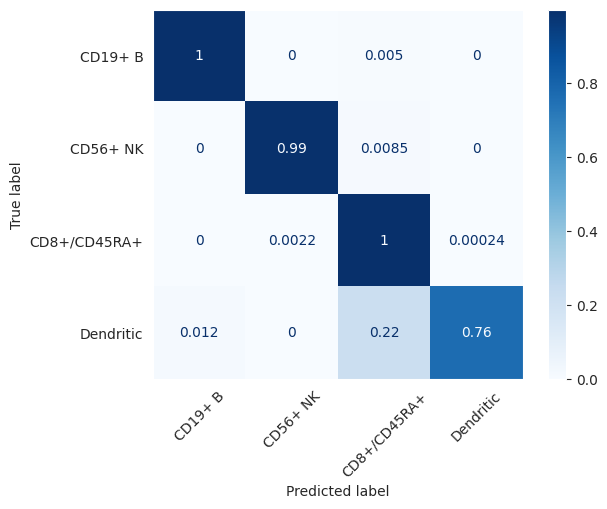

In [22]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=1, min_samples_leaf=1, max_features='sqrt')
evaluate_model(random_forest, X_train, Y_train, X_test, Y_test)

Initial results show the random forest is performing well. The minority class is performing the worst and is often being confused with the majority class, which is expected, but is still being classified reasonably well.

We can try a few different techniques to see if we can improve performance further. First, we can try increasing the number of estimators in the random forest to attempt to reduce the overfitting.

balanced accuracy - Train: 1.0000, Test: 0.9377
f1 - Train: 1.0000, Test: 0.9896


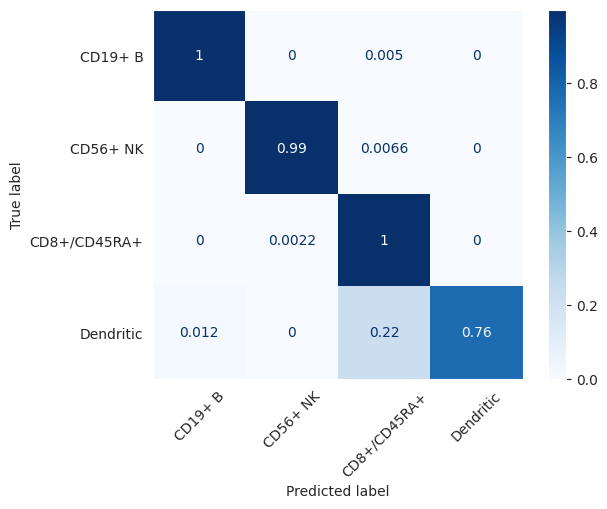

In [23]:
random_forest = RandomForestClassifier(n_estimators=500, random_state=1, min_samples_leaf=1, max_features='sqrt')
evaluate_model(random_forest, X_train, Y_train, X_test, Y_test)

Next we can try to introduce balanced class weights to help the model pay more attention to the minority class.

balanced accuracy - Train: 1.0000, Test: 0.9355
f1 - Train: 1.0000, Test: 0.9880


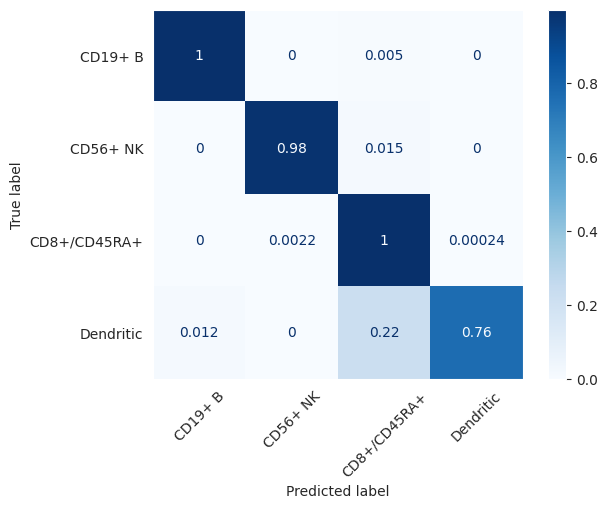

In [24]:
random_forest = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=1, min_samples_leaf=1, max_features='sqrt')
evaluate_model(random_forest, X_train, Y_train, X_test, Y_test)

Neither technique provided a significant improvement over the original random forest model. Next we can try a different model entirely and see how it performs.

balanced accuracy - Train: 1.0000, Test: 0.9385
f1 - Train: 1.0000, Test: 0.9879


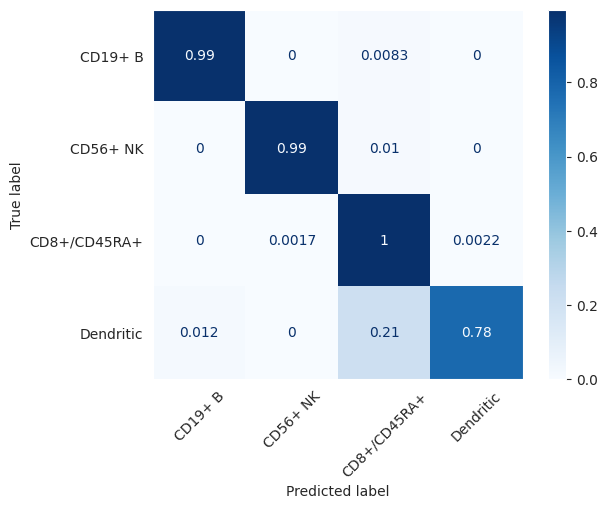

In [25]:
logistic_regression = LogisticRegression(max_iter=1000, random_state=1)
evaluate_model(logistic_regression, X_train, Y_train, X_test, Y_test)

Logistic regression is performing similarly to the random forest, but slightly better on the minority class. There is a similar pattern of misclassification, so it is likely that the features being used are not sufficient to fully separate the classes. Let's try with more features.

balanced accuracy - Train: 0.9996, Test: 0.9372
f1 - Train: 1.0000, Test: 0.9896


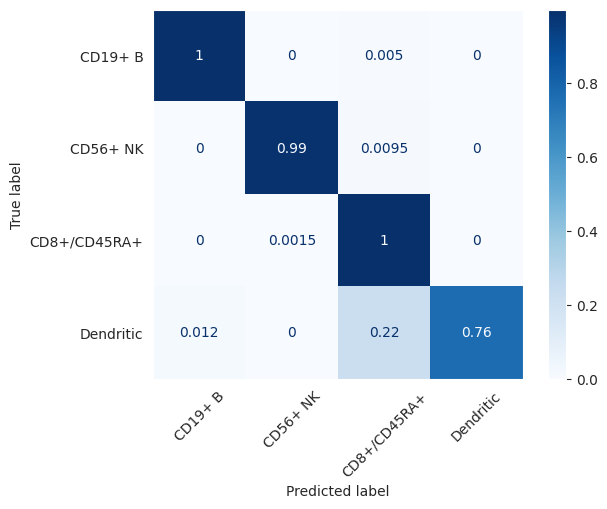

In [26]:
top_idx = mi_id_sort[-6000:]
X_reduced_6k = X.iloc[:, top_idx]
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced_6k, Y, test_size=0.2, random_state=31415)
random_forest = RandomForestClassifier(n_estimators=100, random_state=1, min_samples_leaf=1, max_features='sqrt')
evaluate_model(random_forest, X_train, Y_train, X_test, Y_test)

Tripling the number of features didn't change performance, indicating that the original 2000 features captured most of the useful information for classification. We can also try reducing the number of features to see how low we can go before performance degrades.

In [27]:
metrics_results = {"num_features": [], "balanced_train": [], "balanced_test": [], "f1_train": [], "f1_test": []}
for num_features in range(2000, 0, -200):
    print(f"Evaluating with top {num_features} features")
    top_idx = mi_id_sort[-num_features:]
    X_reduced_n = X.iloc[:, top_idx]
    X_train, X_test, Y_train, Y_test = train_test_split(X_reduced_n, Y, test_size=0.2, random_state=31415)

    random_forest = RandomForestClassifier(n_estimators=100, random_state=1, min_samples_leaf=1, max_features='sqrt')
    random_forest.fit(X_train, Y_train)

    predictions_train = random_forest.predict(X_train)
    metrics_train = score(predictions_train, Y_train)

    predictions_test = random_forest.predict(X_test)
    metrics_test = score(predictions_test, Y_test)

    metrics_results["num_features"].append(num_features)
    metrics_results["balanced_train"].append(metrics_train["balanced accuracy"])
    metrics_results["balanced_test"].append(metrics_test["balanced accuracy"])
    metrics_results["f1_train"].append(metrics_train["f1"])
    metrics_results["f1_test"].append(metrics_test["f1"])

Evaluating with top 2000 features
Evaluating with top 1800 features
Evaluating with top 1600 features
Evaluating with top 1400 features
Evaluating with top 1200 features
Evaluating with top 1000 features
Evaluating with top 800 features
Evaluating with top 600 features
Evaluating with top 400 features
Evaluating with top 200 features


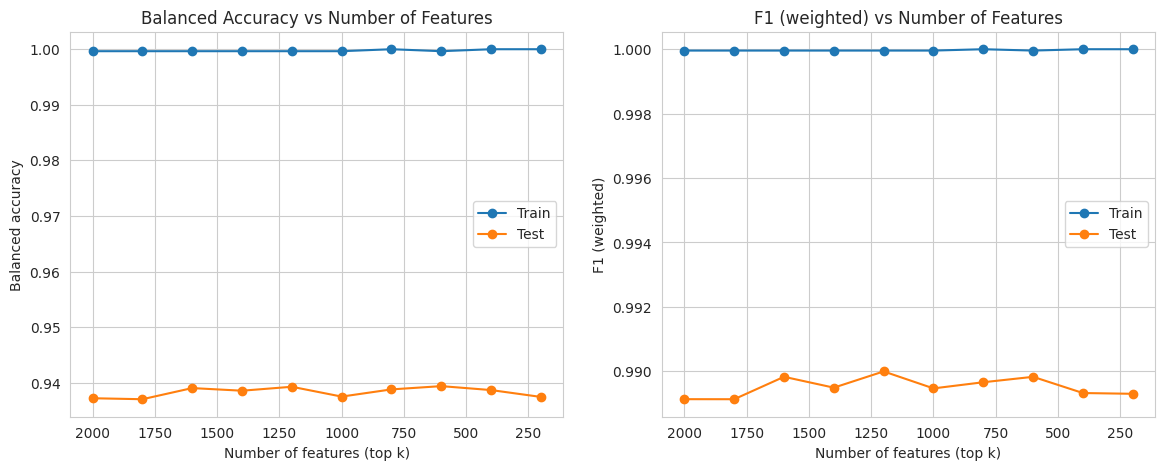

In [28]:
# Plot results
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Balanced accuracy
axes[0].plot(metrics_results["num_features"], metrics_results["balanced_train"], marker="o", label="Train")
axes[0].plot(metrics_results["num_features"], metrics_results["balanced_test"], marker="o", label="Test")
axes[0].set_xlabel("Number of features (top k)")
axes[0].set_ylabel("Balanced accuracy")
axes[0].set_title("Balanced Accuracy vs Number of Features")
axes[0].invert_xaxis()
axes[0].legend()

# F1
axes[1].plot(metrics_results["num_features"], metrics_results["f1_train"], marker="o", label="Train")
axes[1].plot(metrics_results["num_features"], metrics_results["f1_test"], marker="o", label="Test")
axes[1].set_xlabel("Number of features (top k)")
axes[1].set_ylabel("F1 (weighted)")
axes[1].set_title("F1 (weighted) vs Number of Features")
axes[1].invert_xaxis()
axes[1].legend()

plt.show()

The performance of the model is very stable down to 200 features with the variation likely due to random chance from the train/test split. This indicates that a small number of genes are sufficient to accurately classify the cell types in this dataset. We will see how far we can reduce the feature set while maintaining good performance.

In [29]:
metrics_results = {"num_features": [], "balanced_train": [], "balanced_test": [], "f1_train": [], "f1_test": []}
for num_features in range(200, 0, -10):
    print(f"Evaluating with top {num_features} features")
    top_idx = mi_id_sort[-num_features:]
    X_reduced_n = X.iloc[:, top_idx]
    X_train, X_test, Y_train, Y_test = train_test_split(X_reduced_n, Y, test_size=0.2, random_state=31415)

    random_forest = RandomForestClassifier(n_estimators=100, random_state=1, min_samples_leaf=1, max_features='sqrt')
    random_forest.fit(X_train, Y_train)

    predictions_train = random_forest.predict(X_train)
    metrics_train = score(predictions_train, Y_train)

    predictions_test = random_forest.predict(X_test)
    metrics_test = score(predictions_test, Y_test)

    metrics_results["num_features"].append(num_features)
    metrics_results["balanced_train"].append(metrics_train["balanced accuracy"])
    metrics_results["balanced_test"].append(metrics_test["balanced accuracy"])
    metrics_results["f1_train"].append(metrics_train["f1"])
    metrics_results["f1_test"].append(metrics_test["f1"])

Evaluating with top 200 features
Evaluating with top 190 features
Evaluating with top 180 features
Evaluating with top 170 features
Evaluating with top 160 features
Evaluating with top 150 features
Evaluating with top 140 features
Evaluating with top 130 features
Evaluating with top 120 features
Evaluating with top 110 features
Evaluating with top 100 features
Evaluating with top 90 features
Evaluating with top 80 features
Evaluating with top 70 features
Evaluating with top 60 features
Evaluating with top 50 features
Evaluating with top 40 features
Evaluating with top 30 features
Evaluating with top 20 features
Evaluating with top 10 features


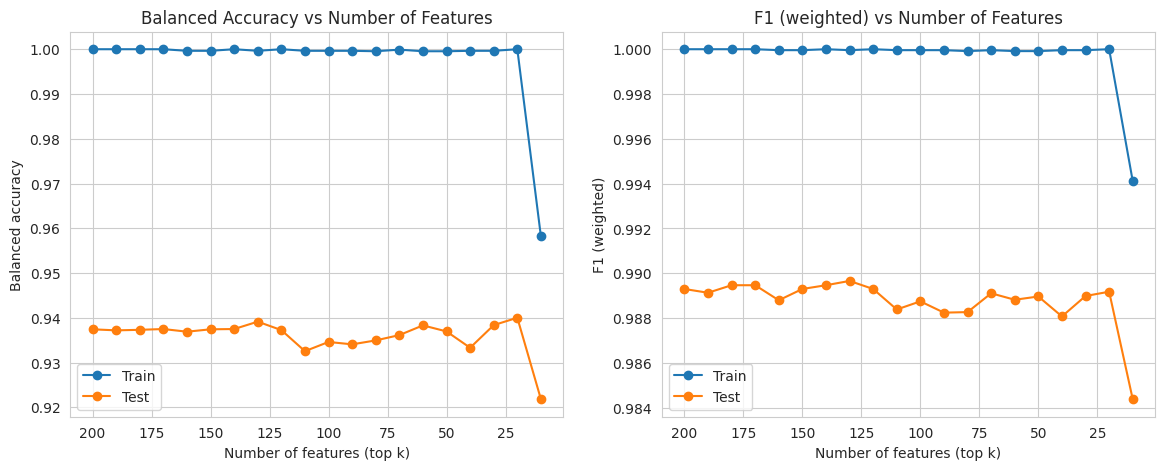

In [30]:
# Plot results
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Balanced accuracy
axes[0].plot(metrics_results["num_features"], metrics_results["balanced_train"], marker="o", label="Train")
axes[0].plot(metrics_results["num_features"], metrics_results["balanced_test"], marker="o", label="Test")
axes[0].set_xlabel("Number of features (top k)")
axes[0].set_ylabel("Balanced accuracy")
axes[0].set_title("Balanced Accuracy vs Number of Features")
axes[0].invert_xaxis()
axes[0].legend()

# F1
axes[1].plot(metrics_results["num_features"], metrics_results["f1_train"], marker="o", label="Train")
axes[1].plot(metrics_results["num_features"], metrics_results["f1_test"], marker="o", label="Test")
axes[1].set_xlabel("Number of features (top k)")
axes[1].set_ylabel("F1 (weighted)")
axes[1].set_title("F1 (weighted) vs Number of Features")
axes[1].invert_xaxis()
axes[1].legend()

plt.show()

Performance is stable all the way down to 20 features. This indicates that there are a small number of genes that are highly informative for distinguishing the cell types in this dataset. We can have a look at the performance of the logistic regression model using only these top 20 features.

balanced accuracy - Train: 0.9450, Test: 0.9314
f1 - Train: 0.9896, Test: 0.9875


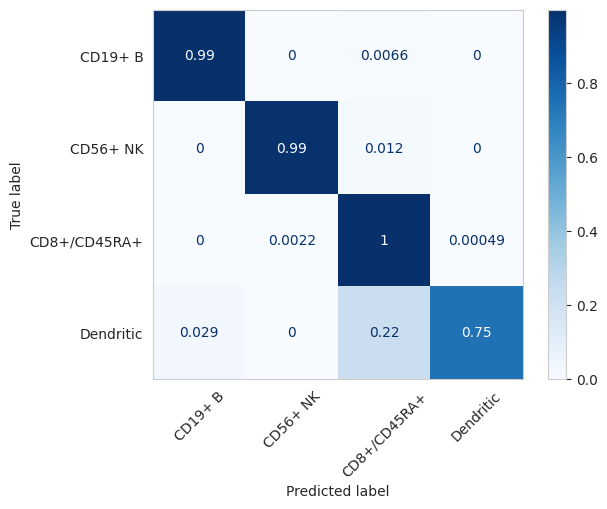

In [31]:
X_reduced_n = X.iloc[:, mi_id_sort[-20:]]
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced_n, Y, test_size=0.2, random_state=31415)
logistic_regression = LogisticRegression(max_iter=1000, random_state=1)
evaluate_model(logistic_regression, X_train, Y_train, X_test, Y_test)

Test performance is unchanged even with only 20 features, indicating that these genes capture most of the useful information for classification. The model is overfitting less with fewer features, as expected.
Let's have a look at which genes were selected as the most informative.

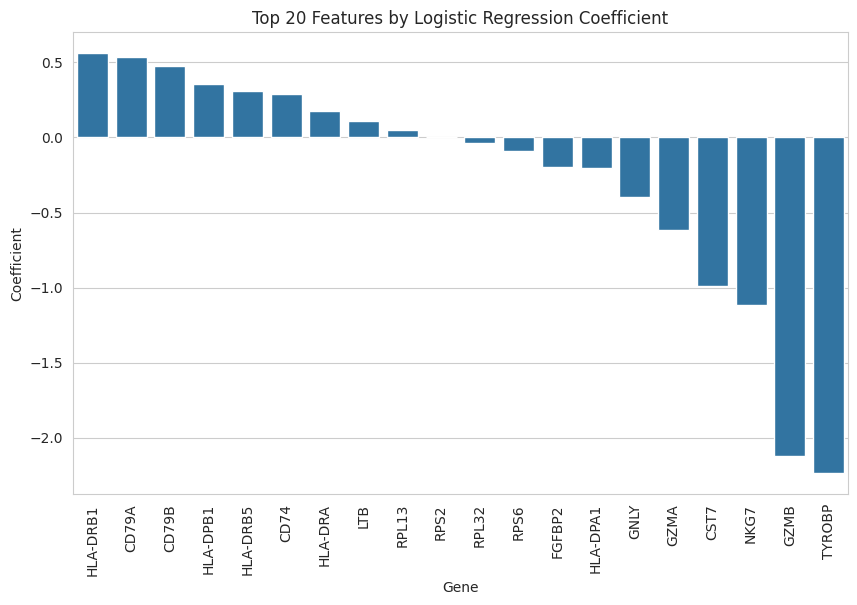

In [32]:
genes = pd.DataFrame(logistic_regression.coef_[0], index=X_reduced_n.columns, columns=["coefficient"]).sort_values(
    by="coefficient", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=genes.index, y=genes["coefficient"])
plt.xticks(rotation=90)
plt.title("Top 20 Features by Logistic Regression Coefficient")
plt.xlabel("Gene")
plt.ylabel("Coefficient")
plt.show()

balanced accuracy - Train: 1.0000, Test: 0.9400
f1 - Train: 1.0000, Test: 0.9892


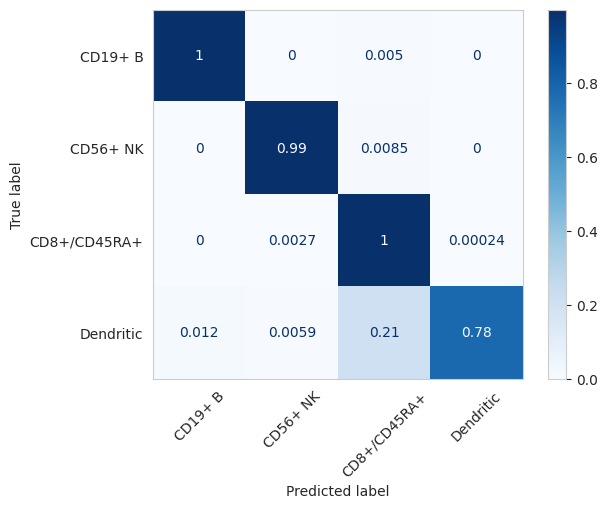

In [33]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=1, min_samples_leaf=1, max_features='sqrt')
evaluate_model(random_forest, X_train, Y_train, X_test, Y_test)

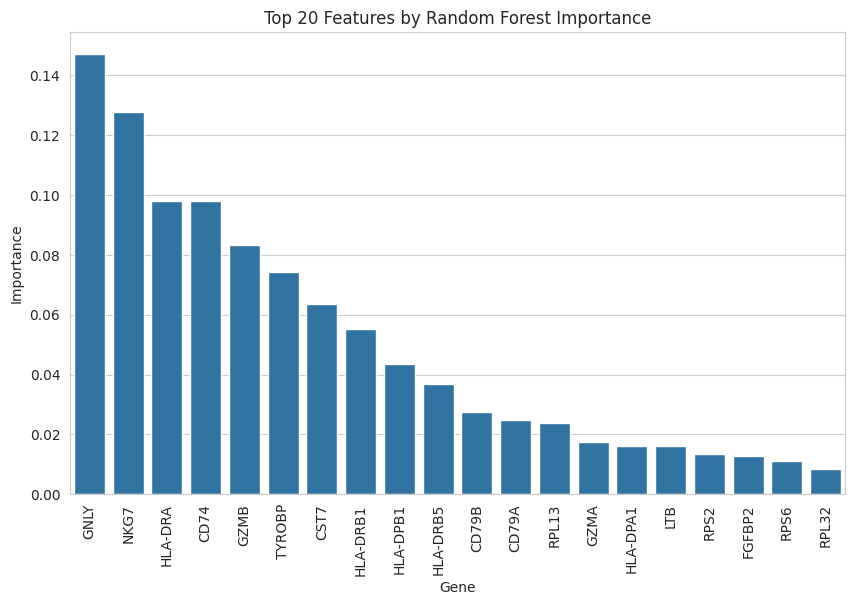

In [34]:
genes = pd.DataFrame(random_forest.feature_importances_, index=X_reduced_n.columns, columns=["importance"]).sort_values(
    by="importance", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=genes.index, y=genes["importance"])
plt.xticks(rotation=90)
plt.title("Top 20 Features by Random Forest Importance")
plt.xlabel("Gene")
plt.ylabel("Importance")
plt.show()

It seems like both models have similar importance on each gene, but we can visualize this better by plotting the importance from the random forest against the coefficient from the logistic regression.
Note that we take the absolute value of the logistic regression coefficients, as the sign only indicates the direction of the effect, not the magnitude.

In [35]:
combined = genes.join(
    pd.DataFrame(abs(logistic_regression.coef_[0]), index=X_reduced_n.columns, columns=["coefficient"]))
combined

,importance,coefficient
GNLY,0.147104,0.399226
NKG7,0.127628,1.115931
HLA-DRA,0.098105,0.178695
CD74,0.097928,0.289846
GZMB,0.083373,2.124491
TYROBP,0.074280,2.236206
CST7,0.063683,0.989523
HLA-DRB1,0.055336,0.560795
HLA-DPB1,0.043676,0.355997
HLA-DRB5,0.036986,0.307186


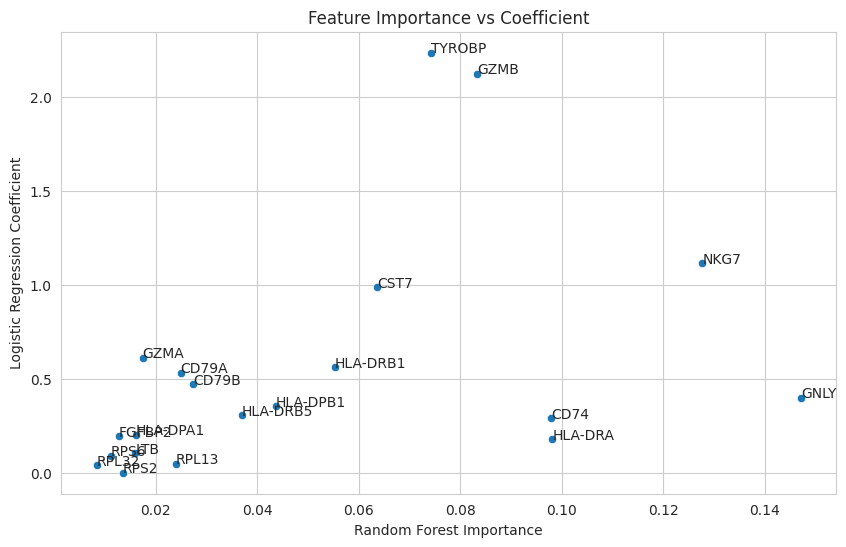

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="importance", y="coefficient", data=combined)
for i in combined.index:
    plt.text(combined.loc[i, "importance"], combined.loc[i, "coefficient"], i)
plt.title("Feature Importance vs Coefficient")
plt.xlabel("Random Forest Importance")
plt.ylabel("Logistic Regression Coefficient")
plt.show()

The low importance/coefficient genes are clustered together, while the high importance/coefficient genes show more variation between the two models, indicating that they are capturing different aspects of the data. Notably, the random forest seems like a smoother importance distribution, while the logistic regression has a few genes with very high coefficients and the rest much lower. This is likely due to the fact that the random forest can capture more complex relationships between features, while the logistic regression is limited to linear relationships.

We can also visualise how the cell types are distributed in lower dimensional space. To get a better idea of how the types are separated.

/home/josh/School/Projects/BINF7000/BINF7000-A3-G16/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:385: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/home/josh/School/Projects/BINF7000/BINF7000-A3-G16/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


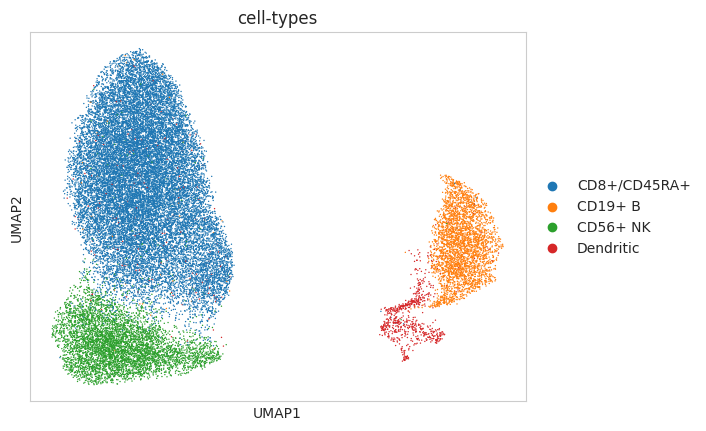

In [37]:
sc.pp.pca(data, n_comps=50)
sc.pp.neighbors(data, n_neighbors=10, n_pcs=50)
sc.tl.umap(data)
sc.pl.umap(data, color="cell-types")

The clusters seem to be fairly well separated. It is a bit hard to see without zooming in, but there is a non-trivial amount of the minority class (Dendritic cells) that overlaps with the majority class, which likely contributes to the misclassifications we are seeing.

In [38]:
test_data = anndata.read_h5ad('data/Test_dataset.h5ad')

Define some dicts to assist in converting values

In [39]:
gene_id_mapping = {"ENSG00000115523": "GNLY",
                   "ENSG00000105374": "NKG7",
                   "ENSG00000204287": "HLA-DRA",
                   "ENSG00000019582": "CD74",
                   "ENSG00000100453": "GZMB",
                   "ENSG00000011600": "TYROBP",
                   "ENSG00000077984": "CST7",
                   "ENSG00000196126": "HLA-DRB1",
                   "ENSG00000223865": "HLA-DPB1",
                   "ENSG00000198502": "HLA-DRB5",
                   "ENSG00000007312": "CD79B",
                   "ENSG00000105369": "CD79A",
                   "ENSG00000167526": "RPL13",
                   "ENSG00000145649": "GZMA",
                   "ENSG00000231389": "HLA-DPA1",
                   "ENSG00000227507": "LTB",
                   "ENSG00000140988": "RPS2",
                   "ENSG00000137441": "FGFBP2",
                   "ENSG00000137154": "RPS6",
                   "ENSG00000144713": "RPL32"}

cell_type_mapping = {
    "CD8+ T cell": "CD8+/CD45RA+",
    "CD4+ T cell": "CD8+/CD45RA+",
    "Other T": "CD8+/CD45RA+",
    "B cell": "CD19+ B",
    "Plasmablast": "CD19+ B",
    "NK cell": "CD56+ NK",
    "cDC": "Dendritic",
    "pDC": "Dendritic",
    "CD14+ Monocyte": "ignored",
    "CD16+ Monocyte": "ignored",
    "Platelet": "ignored"
}

In [40]:
test_df = pd.DataFrame(test_data.X.toarray(), columns=test_data.var_names.tolist())
test_df

,ENSG00000204381,ENSG00000095059,ENSG00000172638,ENSG00000198369,ENSG00000259417,ENSG00000281248,ENSG00000228787,ENSG00000253982,ENSG00000186298,ENSG00000239482,...,ENSG00000188822,ENSG00000257568,ENSG00000145246,ENSG00000071054,ENSG00000249484,ENSG00000197448,ENSG00000225656,ENSG00000188691,ENSG00000124209,ENSG00000166881
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,9.440791,0.0,0.0,0.000000,0.0
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,7.978025,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,7.978025,0.0
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45782,0.0,7.618411,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,9.612894,0.0,0.0,0.000000,0.0
45783,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,7.994356,0.0,...,0.0,0.0,0.0,7.994356,0.0,7.994356,0.0,0.0,0.000000,0.0
45784,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
45785,0.0,0.000000,7.488414,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,7.488414,0.0,0.0,0.000000,0.0


Reduce our dataset down to only the 20 genes we are interested in

In [41]:
reduced_test_df = test_df[gene_id_mapping.keys()]
reduced_test_df

,ENSG00000115523,ENSG00000105374,ENSG00000204287,ENSG00000019582,ENSG00000100453,ENSG00000011600,ENSG00000077984,ENSG00000196126,ENSG00000223865,ENSG00000198502,ENSG00000007312,ENSG00000105369,ENSG00000167526,ENSG00000145649,ENSG00000231389,ENSG00000227507,ENSG00000140988,ENSG00000137441,ENSG00000137154,ENSG00000144713
0,8.913584,8.913584,0.000000,9.912086,0.0,8.913584,0.0,8.913584,8.913584,0.000000,0.0,0.0,13.665587,0.000000,0.000000,11.496051,13.434281,0.0,13.303049,14.268214
1,9.440791,0.000000,9.440791,9.440791,0.0,11.024369,0.0,0.000000,0.000000,0.000000,0.0,0.0,13.831131,9.440791,0.000000,0.000000,11.439234,0.0,13.139314,12.760850
2,7.978025,7.978025,10.558210,11.557733,0.0,11.972651,0.0,10.295368,10.295368,9.559167,0.0,0.0,12.879374,0.000000,0.000000,0.000000,12.830470,0.0,12.557493,12.220520
3,0.000000,0.000000,10.561835,11.146481,0.0,12.883000,0.0,11.146481,9.562790,11.146481,0.0,0.0,13.146003,0.000000,10.561835,9.562790,11.561359,0.0,9.562790,13.146003
4,9.516742,0.000000,9.516742,12.515018,0.0,12.974382,0.0,10.515757,0.000000,0.000000,0.0,0.0,12.100062,0.000000,0.000000,0.000000,12.684915,0.0,10.515757,13.322268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45782,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,13.968692,0.000000,0.000000,9.612894,12.968781,0.0,13.165796,13.339109
45783,0.000000,0.000000,0.000000,0.000000,0.0,10.311751,0.0,7.994356,0.000000,0.000000,0.0,0.0,11.574122,0.000000,7.994356,0.000000,9.990107,0.0,9.575542,11.448635
45784,0.000000,9.467022,0.000000,0.000000,0.0,10.203172,0.0,0.000000,7.886131,0.000000,0.0,0.0,13.128108,8.883079,0.000000,9.467022,11.787318,0.0,12.524120,12.738212
45785,0.000000,7.488414,8.484391,8.484391,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,13.208430,8.484391,0.000000,10.651180,12.802487,0.0,12.609871,12.650507


Setting up dataset for prediction

In [42]:
Y = test_data.obs["cell-types"]
Y.value_counts()

cell-types
CD14+ Monocyte    16158
CD4+ T cell       10710
CD8+ T cell        5488
B cell             4925
NK cell            3587
CD16+ Monocyte     2547
Other T             945
cDC                 574
pDC                 378
Platelet            284
Plasmablast         191
Name: count, dtype: int64

In [43]:
# loop through the Y list and map each to their pre-decided cell type from the training set
Y_adjusted = [(lambda x: cell_type_mapping[x])(x) for x in Y]
# rename the dataset columns to their gene names used during training and reorder them
X = reduced_test_df.rename(gene_id_mapping, axis=1)[X_train.columns.tolist()]

In [44]:
# create a 'mask' of the rows to keep or remove
mask = pd.Series(Y_adjusted) != 'ignored'
Y_original = pd.Series([x[0] for x in zip(Y, mask) if x[1]])
X = X[mask.values]
Y_adjusted = pd.Series(Y_adjusted)[mask]

In [45]:
predictions = random_forest.predict(X)

{'balanced accuracy': 0.7564560954122305, 'f1': 0.6035819900747106}


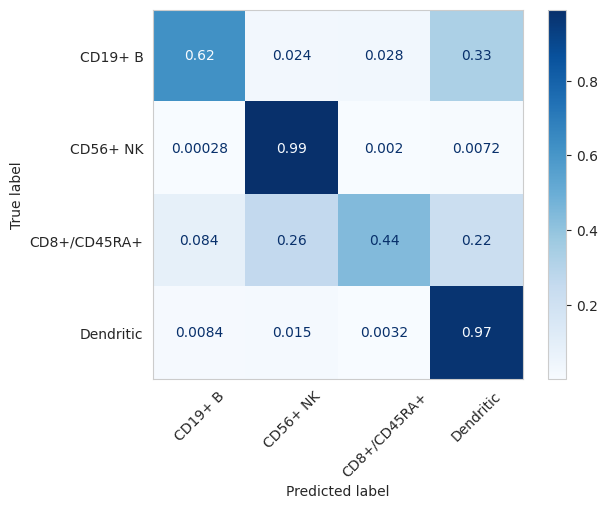

In [46]:
print(score(predictions, Y_adjusted))

cm = confusion_matrix(Y_adjusted, predictions, labels=random_forest.classes_, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_forest.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

Lets have a look at this breakdown per original label

In [47]:
original_label_mapping = defaultdict(list)
for pred, orig in zip(predictions, Y_original):
    original_label_mapping[orig].append(pred)

In [48]:
cell_type_mapping

{'CD8+ T cell': 'CD8+/CD45RA+',
 'CD4+ T cell': 'CD8+/CD45RA+',
 'Other T': 'CD8+/CD45RA+',
 'B cell': 'CD19+ B',
 'Plasmablast': 'CD19+ B',
 'NK cell': 'CD56+ NK',
 'cDC': 'Dendritic',
 'pDC': 'Dendritic',
 'CD14+ Monocyte': 'ignored',
 'CD16+ Monocyte': 'ignored',
 'Platelet': 'ignored'}

/tmp/ipykernel_7169/1244107384.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=heights.index, y=heights.values, order=random_forest.classes_, palette=palette, ax=ax[i])
/tmp/ipykernel_7169/1244107384.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=heights.index, y=heights.values, order=random_forest.classes_, palette=palette, ax=ax[i])
/tmp/ipykernel_7169/1244107384.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=heights.index, y=heights.values, order=random_forest.classes_, palette=palette, ax=ax[i])
/tmp/ipykernel_7169/12

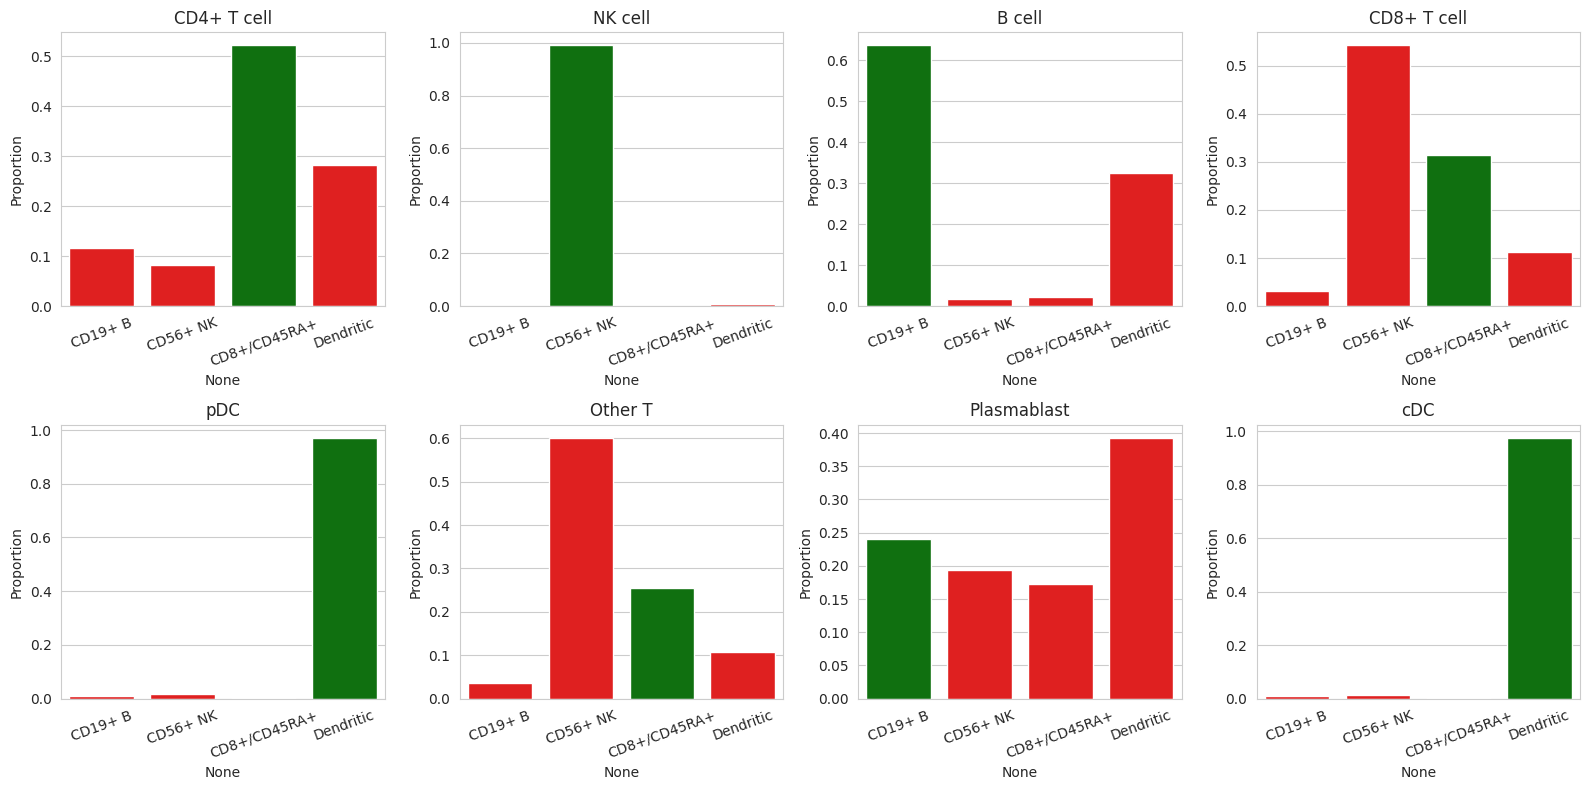

In [49]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax = ax.flatten()

for i, key in enumerate(original_label_mapping.keys()):
    counts = pd.Series(original_label_mapping[key]).value_counts()
    heights = counts / counts.sum()
    palette = {c: "red" if c != cell_type_mapping[key] else "green" for c in random_forest.classes_}

    sns.barplot(x=heights.index, y=heights.values, order=random_forest.classes_, palette=palette, ax=ax[i])

    ax[i].set_title(key)
    ax[i].tick_params(axis='x', rotation=20)
    ax[i].set_ylabel("Proportion")

plt.tight_layout()

The Dendritic cells and CD59+ NK cells are being consistently classified correctly with almost no mistakes in their new cell types.
The other two categories have at least one new cell type that they perform poorly on. Notably there seems to be a significant amount of noise in the CD8+ types, with two of the new types being ~50% classified as NK and the third being mostly correct but with a large portion of dendritic.

{'balanced accuracy': 0.7267341682447263, 'f1': 0.5518756303706006}


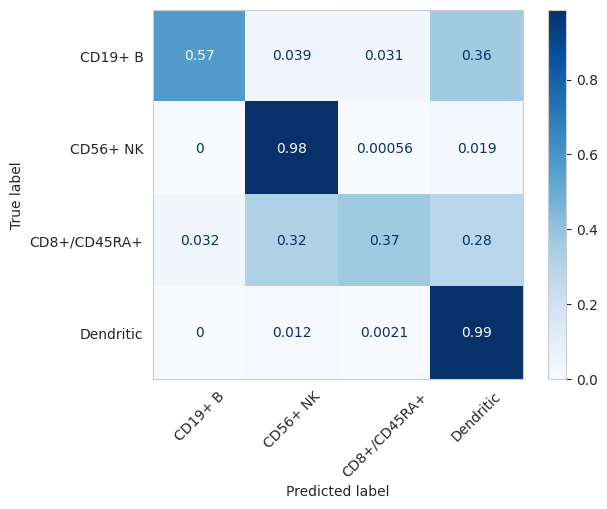

/tmp/ipykernel_7169/325032835.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=heights.index, y=heights.values, order=random_forest.classes_, palette=palette, ax=ax[i])
/tmp/ipykernel_7169/325032835.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=heights.index, y=heights.values, order=random_forest.classes_, palette=palette, ax=ax[i])
/tmp/ipykernel_7169/325032835.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=heights.index, y=heights.values, order=random_forest.classes_, palette=palette, ax=ax[i])
/tmp/ipykernel_7169/32

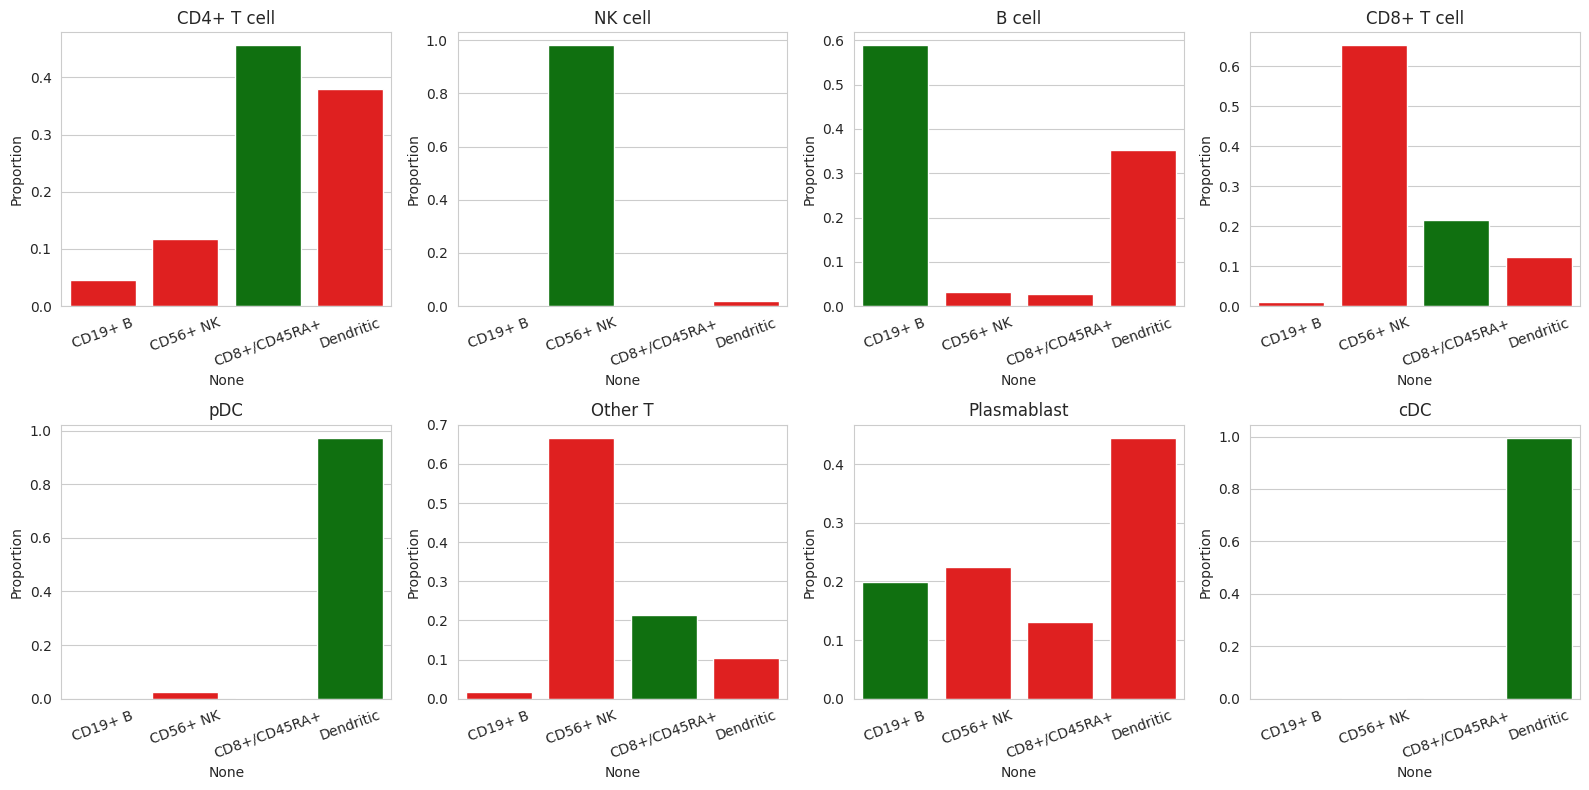

In [50]:
predictions = logistic_regression.predict(X)
print(score(predictions, Y_adjusted))

cm = confusion_matrix(Y_adjusted, predictions, labels=random_forest.classes_, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_forest.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

original_label_mapping = defaultdict(list)
for pred, orig in zip(predictions, Y_original):
    original_label_mapping[orig].append(pred)

fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax = ax.flatten()

for i, key in enumerate(original_label_mapping.keys()):
    counts = pd.Series(original_label_mapping[key]).value_counts()
    heights = counts / counts.sum()
    palette = {c: "red" if c != cell_type_mapping[key] else "green" for c in random_forest.classes_}

    sns.barplot(x=heights.index, y=heights.values, order=random_forest.classes_, palette=palette, ax=ax[i])

    ax[i].set_title(key)
    ax[i].tick_params(axis='x', rotation=20)
    ax[i].set_ylabel("Proportion")

plt.tight_layout()

Logistic regression achieves very similar results as expected by their similarity in training. The results to tend slightly worse on the classes random forest was doing poorly on.

Interestingly, there seems to be a relatively high degree of misclassification towards Dendritic in both cases which may be a consequence of overfitting for the minority class during training. This is also reinforced by the high performance of the Dendritic cells.